In [ ]:
import logging
import time

import btk
import galsim
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scarlet
import scarlet.psf
import seaborn as sns
import sep
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.Deblender import Deblend
from maddeb.extraction import extract_cutouts
from maddeb.metrics import (
    compute_apperture_photomery,
    compute_pixel_covariance_and_flux,
)


2022-07-25 14:23:59.601066: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-07-25 14:23:59.601157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100.2
max_number = 10
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed=3

galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [ ]:
blend = next(draw_generator)

Generating blends for LSST survey:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
field_images = blend["blend_images"]
isolated_images = blend["isolated_images"]

# Deblend with Scarlet

In [ ]:
np.shape(field_images)

(1, 6, 501, 501)

In [ ]:
psf = np.array([p.drawImage(galsim.Image(field_images[0].shape[1],field_images[0].shape[2]),scale=survey.pixel_scale.to_value("arcsec")).array for p in blend["psf"]])
bands=[f for f in survey._filters]
wcs = blend["wcs"]

In [ ]:
import scarlet.psf
from scarlet.psf import ImagePSF

In [ ]:
def predict_with_scarlet(image, x_pos, y_pos, show_scene, show_sources, filters):
    sig = []
    weights = np.ones_like(image)
    for i in range(6):
        sig.append(sep.Background(image[i]).globalrms)
        weights[i] = weights[i] / (sig[i]**2)
    observation = scarlet.Observation(
            image, psf=scarlet.psf.ImagePSF(psf), weights= weights, channels=bands, wcs=wcs
        )
    
    model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(filters))
    model_frame = scarlet.Frame(
    image.shape,
    psf=model_psf,
    channels=filters, wcs=wcs)

    
    observation = observation.match(model_frame)
    sources = []
    for i in range(len(x_pos)):
        result = scarlet.ExtendedSource(
            model_frame,
            model_frame.get_sky_coord((x_pos[i], y_pos[i])),
            observation,
            thresh=1,
            shifting=True,
        )
        sources.append(result)

    scarlet.initialization.set_spectra_to_match(sources, observation)
    
    scarlet_blend = scarlet.Blend(sources, observation)
    
    %time it, logL = scarlet_blend.fit(200, e_rel=1e-5)
    #print(f"scarlet ran for {it} iterations to logL = {logL}")
    #scarlet.display.show_likelihood(scarlet_blend)
    #plt.show()
    
    if show_scene:
        scarlet.display.show_scene(sources,
                           norm=None,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
        
        plt.show()
    
    if show_sources:
        scarlet.display.show_sources(sources,
                                 norm=None,
                                 observation=observation,
                                 show_rendered=True,
                                 show_observed=True,
                                 add_boxes=True
                                )
        plt.show()
    
    predicted_sources = []
    for src in sources:
        predicted_sources.append(observation.render(src.get_model(frame=model_frame)))
    #print(np.shape(src.get_model(frame=model_frame)))
    return predicted_sources

In [ ]:
image = field_images[0]

In [ ]:
x_pos = blend['blend_list'][0]['y_peak']
y_pos = blend['blend_list'][0]['x_peak']

In [ ]:
#model = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=True, show_sources=True, filters=bands)

In [ ]:
#plt.imshow(model[0][2])

In [ ]:
scarlet_predictions=[]
for i, image in enumerate(field_images):
    image = field_images[i]
    x_pos = blend['blend_list'][i]['y_peak']
    y_pos = blend['blend_list'][i]['x_peak']
    predicted_sources = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=False, show_sources=False, filters=bands)
    scarlet_predictions.append(predicted_sources)

Completed 5 iterations and [4, 40, 0, 4, 40, 0, 4, 37, 0, 4, 38, 0, 4, 40, 0, 4, 39, 0, 4, 40, 0, 4, 40, 0, 4, 39, 0] sub-iterations
scarlet ran for 14 iterations to logL = -10460664.990487773


CPU times: user 30.3 s, sys: 20.3 s, total: 50.6 s
Wall time: 50 s


# Deblend with MADNESS

In [ ]:
from maddeb.Deblender import Deblend
import tensorflow as tf
import tensorflow_probability as tfp


madness_predictions = []
for i in range(len(blend['blend_list'])):

    current_field_predictions = []
    blends = blend['blend_list'][i]
    #print(blends)
    detected_positions = []
    for j in range(len(blends)):
        detected_positions.append([blends['y_peak'][j], blends['x_peak'][j]])

    deb = Deblend(field_images[i], 
                  detected_positions,
                  latent_dim=8, 
                  num_components=len(blends), 
                  use_likelihood=True, 
                  linear_norm_coeff=80000,
                  max_iter=300)
    #tf.config.run_functions_eagerly(False)
    convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.0000001*45*45*len(blends)*3, min_num_steps=50, window_size=20)
    #convergence_criterion = None
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.06, decay_steps=15, decay_rate=0.8, staircase=True)
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler, momentum=0.1)

    deb(convergence_criterion, optimizer=optimizer, use_debvader=True, compute_sig_dynamically=False)
    
    padding_infos = deb.get_padding_infos()
    for component_num in range(deb.num_components):
        prediction = np.pad(deb.components[component_num], padding_infos[component_num])
        prediction = np.transpose(prediction, axes=(2, 0, 1))
        current_field_predictions.append(prediction)
    madness_predictions.append(current_field_predictions)

2022-07-25 14:25:34.205215: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-07-25 14:25:34.205339: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-25 14:25:34.205429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-07-25 14:25:34.220147: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499995000 Hz
2022-07-25 14:25:34.221377: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5632b02e09a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-25 14:25:34.221418: I tensorflow/compiler/xla

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow/python/ops/linalg/linear_operator_lower_triangular.py:151: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with batch_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with event_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
2022-07-25 14:25:43.840431: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this m

In [ ]:
madness_predictions= np.array(madness_predictions)

In [ ]:
np.shape(madness_predictions)

(1, 9, 6, 501, 501)

In [ ]:
from maddeb.extraction import extract_cutouts
from maddeb.metrics import compute_pixel_covariance_and_flux, compute_pixel_covariance_and_fluxes

In [ ]:
madness_cov = []
madness_actual_flux = []
madness_predicted_flux = []
for blend_number in range(len(field_images)):

    current_galaxies = isolated_images[blend_number]
    madness_res = compute_pixel_covariance_and_fluxes(madness_predictions[blend_number], current_galaxies, field_images[0])

    madness_cov.append(madness_res[0])
    madness_actual_flux.append(madness_res[1])
    madness_predicted_flux.append(madness_res[2])

# Compare: Covariance matrix and flux reconstruction

In [ ]:
scarlet_cov = []
scarlet_actual_flux = []
scarlet_predicted_flux = []

for blend_number in range(len(field_images)):

    current_galaxies = isolated_images[blend_number]
    scarlet_res = compute_pixel_covariance_and_fluxes(scarlet_predictions[blend_number], current_galaxies, field_images[0])

    scarlet_cov.append(scarlet_res[0])
    scarlet_actual_flux.append(scarlet_res[1])
    scarlet_predicted_flux.append(scarlet_res[2])

In [ ]:
scarlet_cov

[array([0.99875075, 0.99942939, 0.99536009, 0.99750832, 0.99812185,
        0.99750468, 0.99825576, 0.99740119, 0.99910956])]

NameError: name 'cov_madness' is not defined

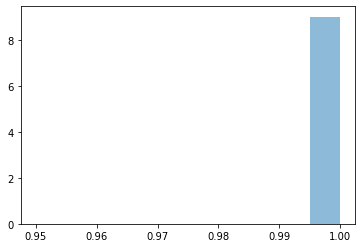

In [ ]:
bins = np.arange(.95, 1, .005)
plt.hist(scarlet_cov, bins=bins, alpha=0.5, label="scarlet");
plt.hist(cov_madness, bins=bins, alpha=0.7, label="MADNESS");
plt.legend()
plt.xlim([.95, 1])

In [ ]:
scarlet_actual_flux = np.array(scarlet_actual_flux)
scarlet_predicted_flux = np.array(scarlet_predicted_flux)

scarlet_relative_difference= np.divide(scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux)

In [ ]:
madness_actual_flux = np.array(madness_actual_flux)
madness_predicted_flux = np.array(madness_predicted_flux)

madness_relative_difference= np.divide(madness_predicted_flux - madness_actual_flux, madness_actual_flux)

In [ ]:
scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1)

In [ ]:
np.array_equal(madness_actual_flux, scarlet_actual_flux)

In [ ]:
from scipy.optimize import curve_fit
def gauss(x, sig, mu):
    return 1/np.sqrt(2.*np.pi)/sig*np.exp(-0.5*(x-mu)**2/sig**2)

n_bins=100
hist, bin_tmp = np.histogram(madness_relative_difference, n_bins, density=True)
bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

hist, bin_tmp = np.histogram(scarlet_relative_difference, n_bins, density=True)
bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

In [ ]:
madness_fit

In [ ]:
bins

In [ ]:
import seaborn as sns
from scipy.stats import norm
#print(madness_relative_difference[np.logical_not(np.isinf(madness_relative_difference))].reshape(-1))
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'black',
                     'figure.facecolor': '1',
                     'xtick.color': 'black',
                     'ytick.color': 'black',
                     'text.color': 'black',
                     'image.cmap': 'viridis',})
plt.figure(figsize=(10,7))
bins = np.arange(-.5,.5, .01)
plt.hist(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))].reshape(-1), bins=bins, density=True, alpha=0.7, color="coral", label="MADNESS");
plt.plot(bins, norm.pdf(bins, madness_fit[0][1], madness_fit[0][0]), color="coral")
plt.hist(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1), bins=bins, density=True, alpha=0.5, color="cornflowerblue", label="scarlet");
plt.plot(bins, norm.pdf(bins, scarlet_fit[0][1], scarlet_fit[0][0]), color="cornflowerblue")
plt.legend(fontsize=20)
ax=plt.gca()
plt.xlabel("relative flux reconstruction error", fontsize=20)
ax.tick_params(labelsize=15)
plt.ylabel("number of galaxies", fontsize=20)
plt.xlim([-.5,.5])
plt.savefig("flux_err", transparent=True)

In [ ]:
print(np.amax(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))]))
print(np.amin(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))]))

In [ ]:
print(np.amax(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))]))
print(np.amin(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))]))

# Compute Apperture photometry

In [ ]:
from maddeb.metrics import compute_apperture_photomery

In [ ]:
actual_residual_field = blend["blend_images"][0]
scarlet_residual_field = blend["blend_images"][0]

for i in range(len(scarlet_predictions[0])):
    actual_residual_field = actual_residual_field - blend["isolated_images"][0][i]
    scarlet_residual_field = scarlet_residual_field - scarlet_predictions[0][i]

padding_infos = deb.get_padding_infos()
madness_residual_field = deb.compute_residual(
    blend["blend_images"][0], use_scatter_and_sub=True
).numpy()

bkg_rms = {}
for band in range(6):
    bkg_rms[band] = sep.Background(blend["blend_images"][0][band]).globalrms

print(len(blend["isolated_images"][0]))
print(len(blend["blend_list"][0]["x_peak"]))
print(np.shape(blend["isolated_images"][0]))
actual_gal_fluxes, actual_gal_fluxerrs, actual_gal_flags = compute_apperture_photomery(
    residual_field=actual_residual_field,
    predictions=blend["isolated_images"][0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

(
    madness_gal_fluxes,
    madness_gal_fluxerrs,
    madness_gal_flags,
) = compute_apperture_photomery(
    residual_field=np.transpose(madness_residual_field,  axes=(2, 0, 1)),
    predictions=madness_predictions[0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

(
    scarlet_gal_fluxes,
    scarlet_gal_fluxerrs,
    scarlet_gal_flags,
) = compute_apperture_photomery(
    residual_field=scarlet_residual_field,
    predictions=scarlet_predictions[0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

plt.figure(figsize=(10, 7))
bins = np.arange(0, 1, 0.005)
plt.hist(
    np.abs((madness_gal_fluxes - actual_gal_fluxes) / actual_gal_fluxes),
    bins=bins,
    alpha=0.5,
    label="MADNESS",
)
print(np.shape(scarlet_gal_fluxes))
plt.hist(
    np.abs((scarlet_gal_fluxes - actual_gal_fluxes) / actual_gal_fluxes),
    bins=bins,
    alpha=0.5,
    label="scarlet",
)

plt.legend(fontsize=20)

plt.savefig("aperturephoto")


In [ ]:
np.shape(madness_residual_field)

In [ ]:
scarlet_gal_fluxes

In [ ]:
actual_gal_fluxes

In [ ]:
madness_gal_fluxes